<a href="https://colab.research.google.com/github/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/blob/master/face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import SGD, Adam


In [8]:
!wget https://github.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/blob/master/Physiological-Feature-Extraction-using-Thermal-Imaging.zip?raw=true -O data.zip
!unzip data.zip

--2020-08-09 23:32:18--  https://github.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/blob/master/Physiological-Feature-Extraction-using-Thermal-Imaging.zip?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/raw/master/Physiological-Feature-Extraction-using-Thermal-Imaging.zip [following]
--2020-08-09 23:32:19--  https://github.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/raw/master/Physiological-Feature-Extraction-using-Thermal-Imaging.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/master/Physiological-Feature-Extraction-using-Thermal-Imaging.zip [following]
--2020

In [9]:
x = np.load( "train_images.npy") / 255
x = x.reshape(2935, 192, 256, 1)

In [10]:
y = np.load('bounding_box.npy')
y[:, 0], y[:, 1] = y[:, 0] / 256, y[:,1]/256
y[:, 2], y[:, 3] = y[:, 2] / 192, y[:,3]/192

In [11]:
n = x.shape[0]
indices = list(range(n))
train_indices = np.random.choice(indices, size = int(n * 0.7), replace = False)
valid_indices = list(set(indices) - set(train_indices))
valid_indices = np.random.choice(valid_indices, size = int(len(valid_indices) * 0.5), replace = False)
test_indices = list(set(indices) - set(train_indices).union(set(valid_indices)))

In [12]:
x_train = x[train_indices]
y_train = y[train_indices]
x_valid = x[valid_indices]
y_valid = y[valid_indices]
x_test = x[test_indices]
y_test = y[test_indices]

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



(2054, 192, 256, 1)
(2054, 4)
(441, 192, 256, 1)
(441, 4)


In [14]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding = 'same', activation='tanh', input_shape=(192, 256, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='sigmoid'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

In [15]:
history = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data = (x_valid, y_valid), verbose = 1)

Epoch 1/100
17/17 [==============================] - 2s 129ms/step - loss: 0.0135 - val_loss: 0.0056
Epoch 2/100
17/17 [==============================] - 2s 120ms/step - loss: 0.0066 - val_loss: 0.0033
Epoch 3/100
17/17 [==============================] - 2s 120ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 4/100
17/17 [==============================] - 2s 120ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 5/100
17/17 [==============================] - 2s 120ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 6/100
17/17 [==============================] - 2s 121ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 7/100
17/17 [==============================] - 2s 121ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 8/100
17/17 [==============================] - 2s 121ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 9/100
17/17 [==============================] - 2s 119ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 10/100
17/17 [==============================] - 2s 121ms/step - loss: 0.0031 - val_lo

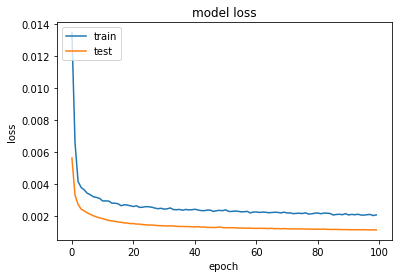

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

(441, 4)
(441, 4)


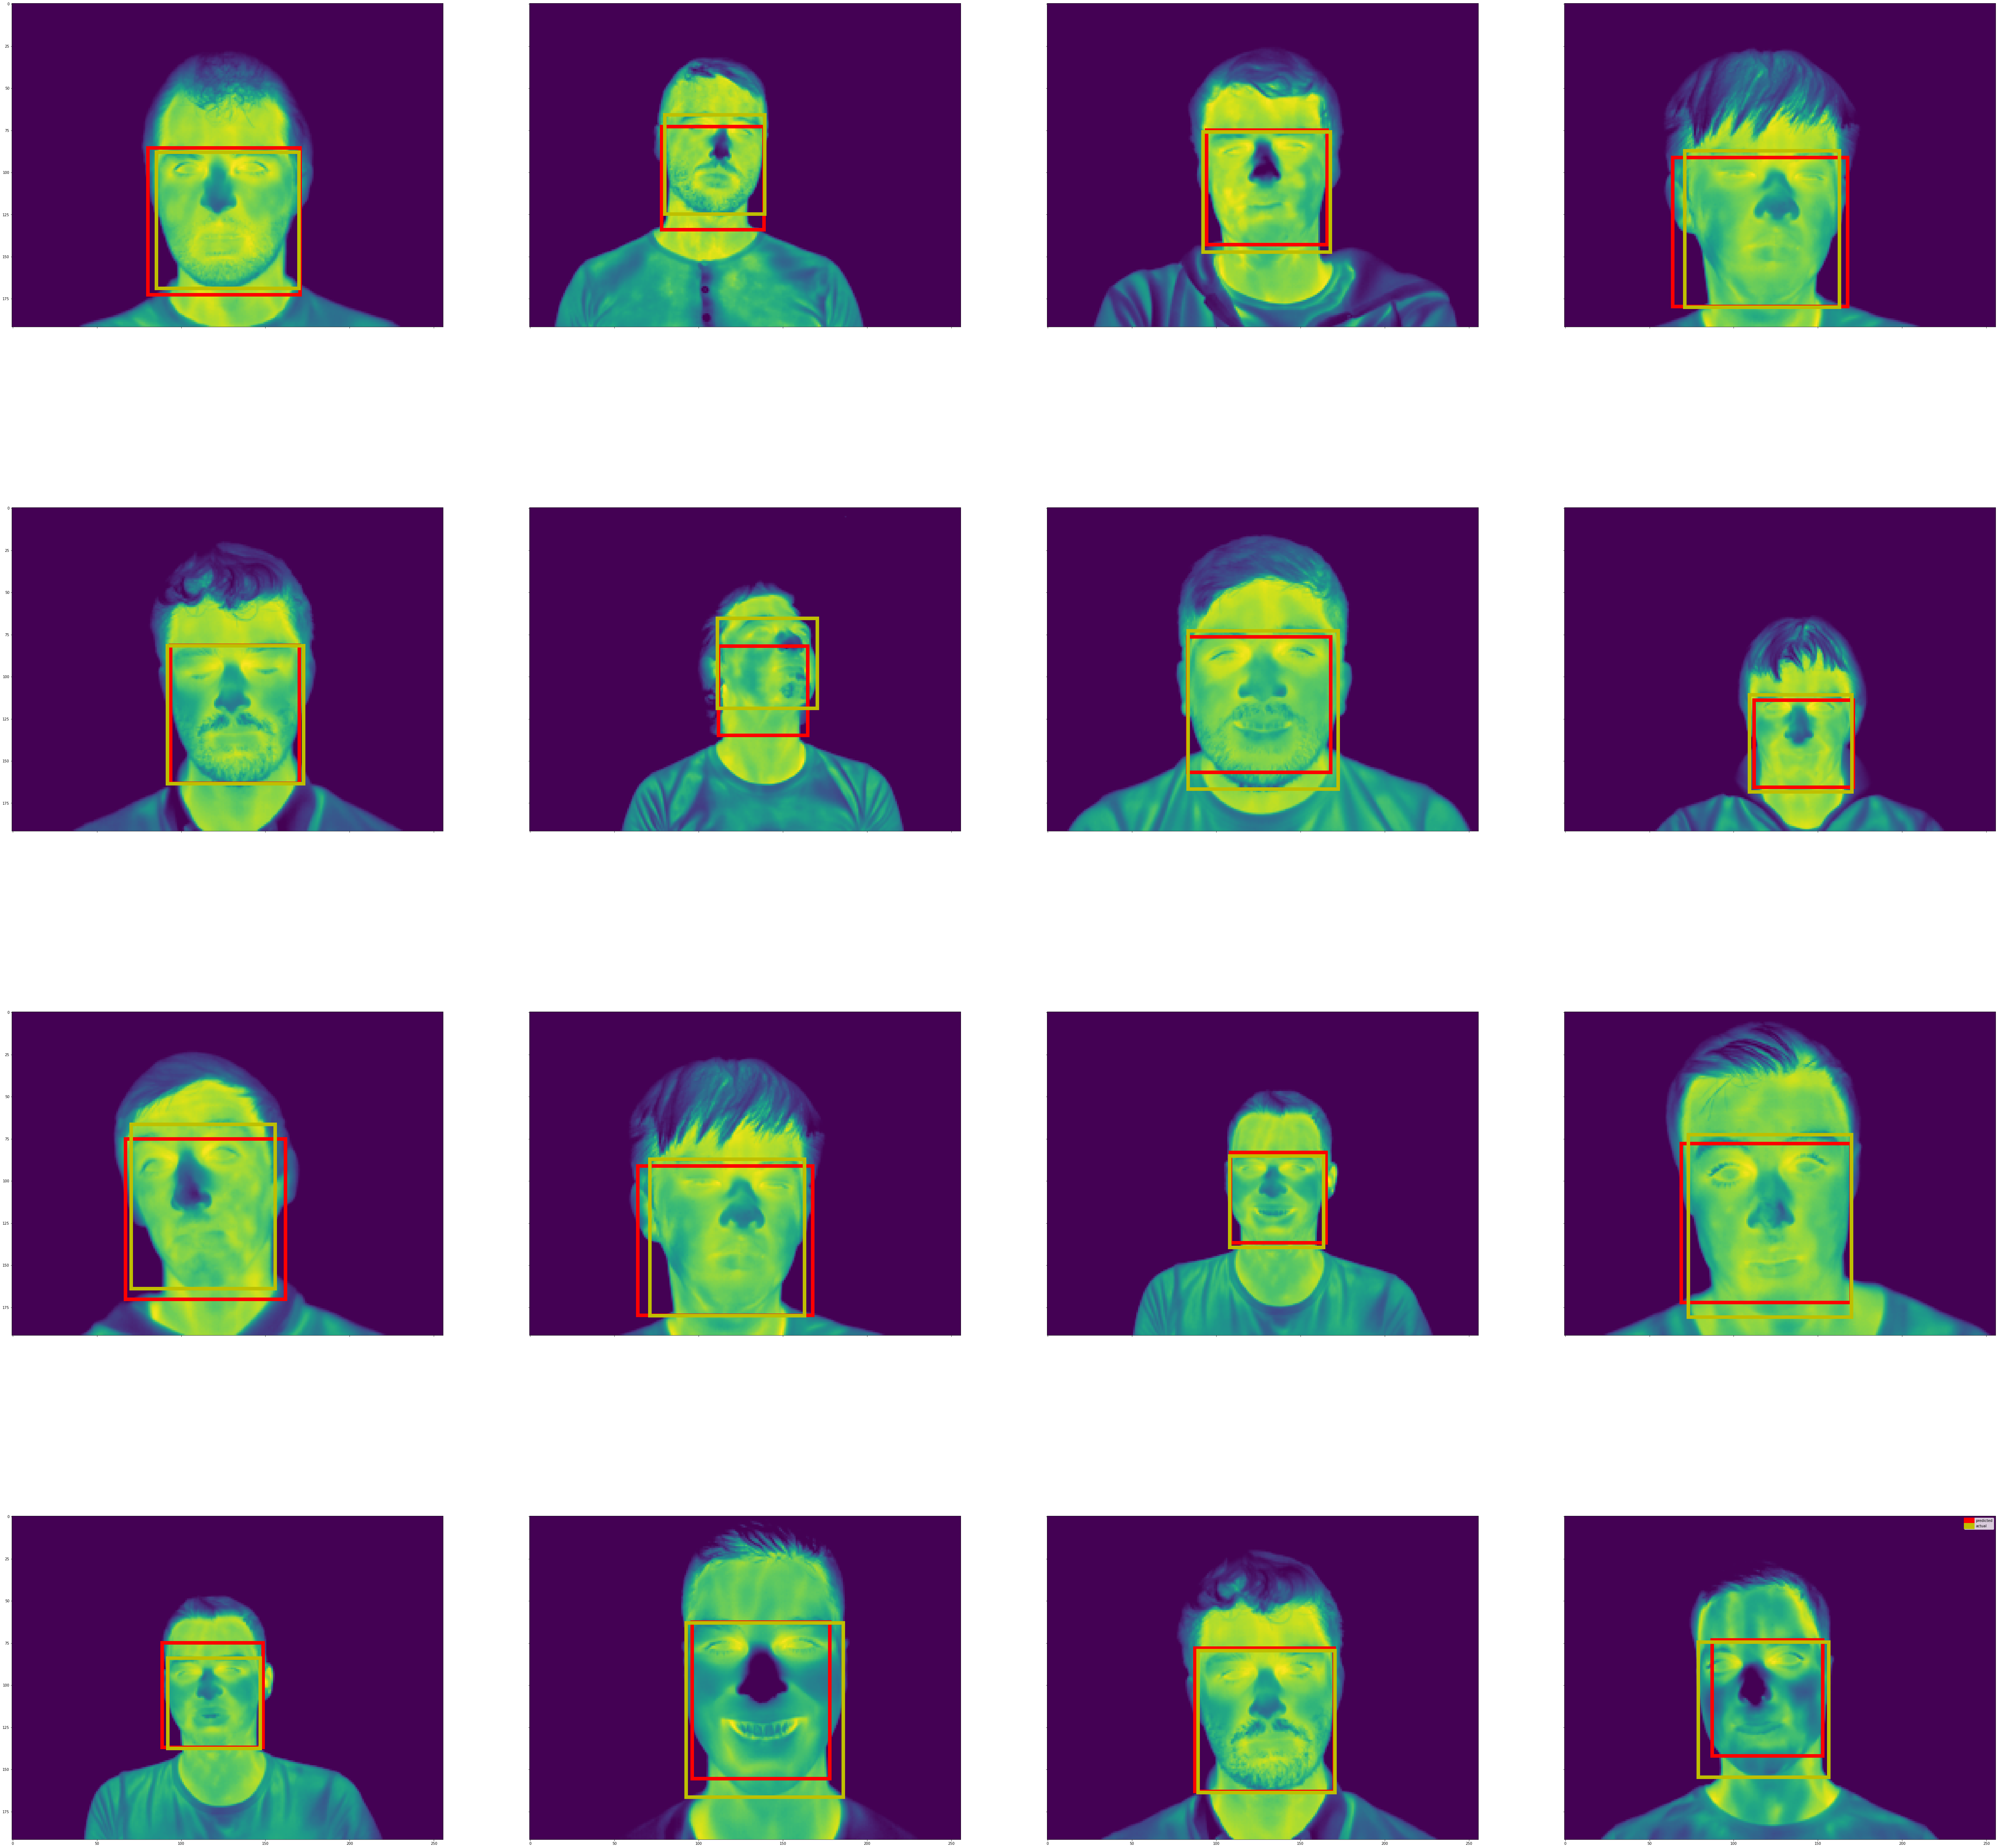

In [18]:
print(y_test_pred.shape)
print(y_test.shape)

def plot_predictions(predicted_set):
  n = 0
  nrows = 4
  ncols = 4
  irand=np.random.choice(y_test.shape[0],nrows*ncols)
  fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=[100,100])
  for row in range(nrows):
    for col in range(ncols):

      to_image = np.reshape(x_test[irand[n]], (192, 256)) * 255
      ax[row,col].imshow(to_image)

      # Create a Rectangle patch
      predicted = list(predicted_set[irand[n]])
      rect = patches.Rectangle((predicted[0] * 256,predicted[2] * 192),(predicted[1] - predicted[0]) * 256,(predicted[3] - predicted[2])*192,linewidth=10,edgecolor='r',facecolor='none', label = 'predicted')
      # Add the patch to the Axes
      ax[row,col].add_patch(rect)

      predicted = list(y_test[irand[n]])
      rect = patches.Rectangle((predicted[0] * 256,predicted[2] * 192),(predicted[1] - predicted[0]) * 256,(predicted[3] - predicted[2])*192,linewidth=10,edgecolor='y',facecolor='none', label = 'actual')
      # Add the patch to the Axes
      ax[row,col].add_patch(rect)
      n += 1

  plt.legend()
  plt.show()

plot_predictions(y_test_pred)


In [19]:
from tensorflow.keras import regularizers
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding = 'same', activation='tanh', input_shape=(192, 256, 1)))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(256, activation='tanh', kernel_regularizer=regularizers.l2(1e-4)))
model2.add(Dropout(0.5))
model2.add(Dense(4, activation='sigmoid'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(loss='mean_squared_error', optimizer=sgd)
history = model2.fit(x_train, y_train, batch_size=128, epochs=100, validation_data = (x_valid, y_valid), verbose = 1)

Epoch 1/100
17/17 [==============================] - 3s 148ms/step - loss: 0.0663 - val_loss: 0.0600
Epoch 2/100
17/17 [==============================] - 2s 139ms/step - loss: 0.0567 - val_loss: 0.0535
Epoch 3/100
17/17 [==============================] - 2s 139ms/step - loss: 0.0542 - val_loss: 0.0532
Epoch 4/100
17/17 [==============================] - 2s 141ms/step - loss: 0.0537 - val_loss: 0.0529
Epoch 5/100
17/17 [==============================] - 2s 140ms/step - loss: 0.0536 - val_loss: 0.0525
Epoch 6/100
17/17 [==============================] - 2s 141ms/step - loss: 0.0535 - val_loss: 0.0525
Epoch 7/100
17/17 [==============================] - 2s 141ms/step - loss: 0.0533 - val_loss: 0.0528
Epoch 8/100
17/17 [==============================] - 2s 142ms/step - loss: 0.0533 - val_loss: 0.0525
Epoch 9/100
17/17 [==============================] - 2s 142ms/step - loss: 0.0531 - val_loss: 0.0524
Epoch 10/100
17/17 [==============================] - 2s 141ms/step - loss: 0.0530 - val_lo

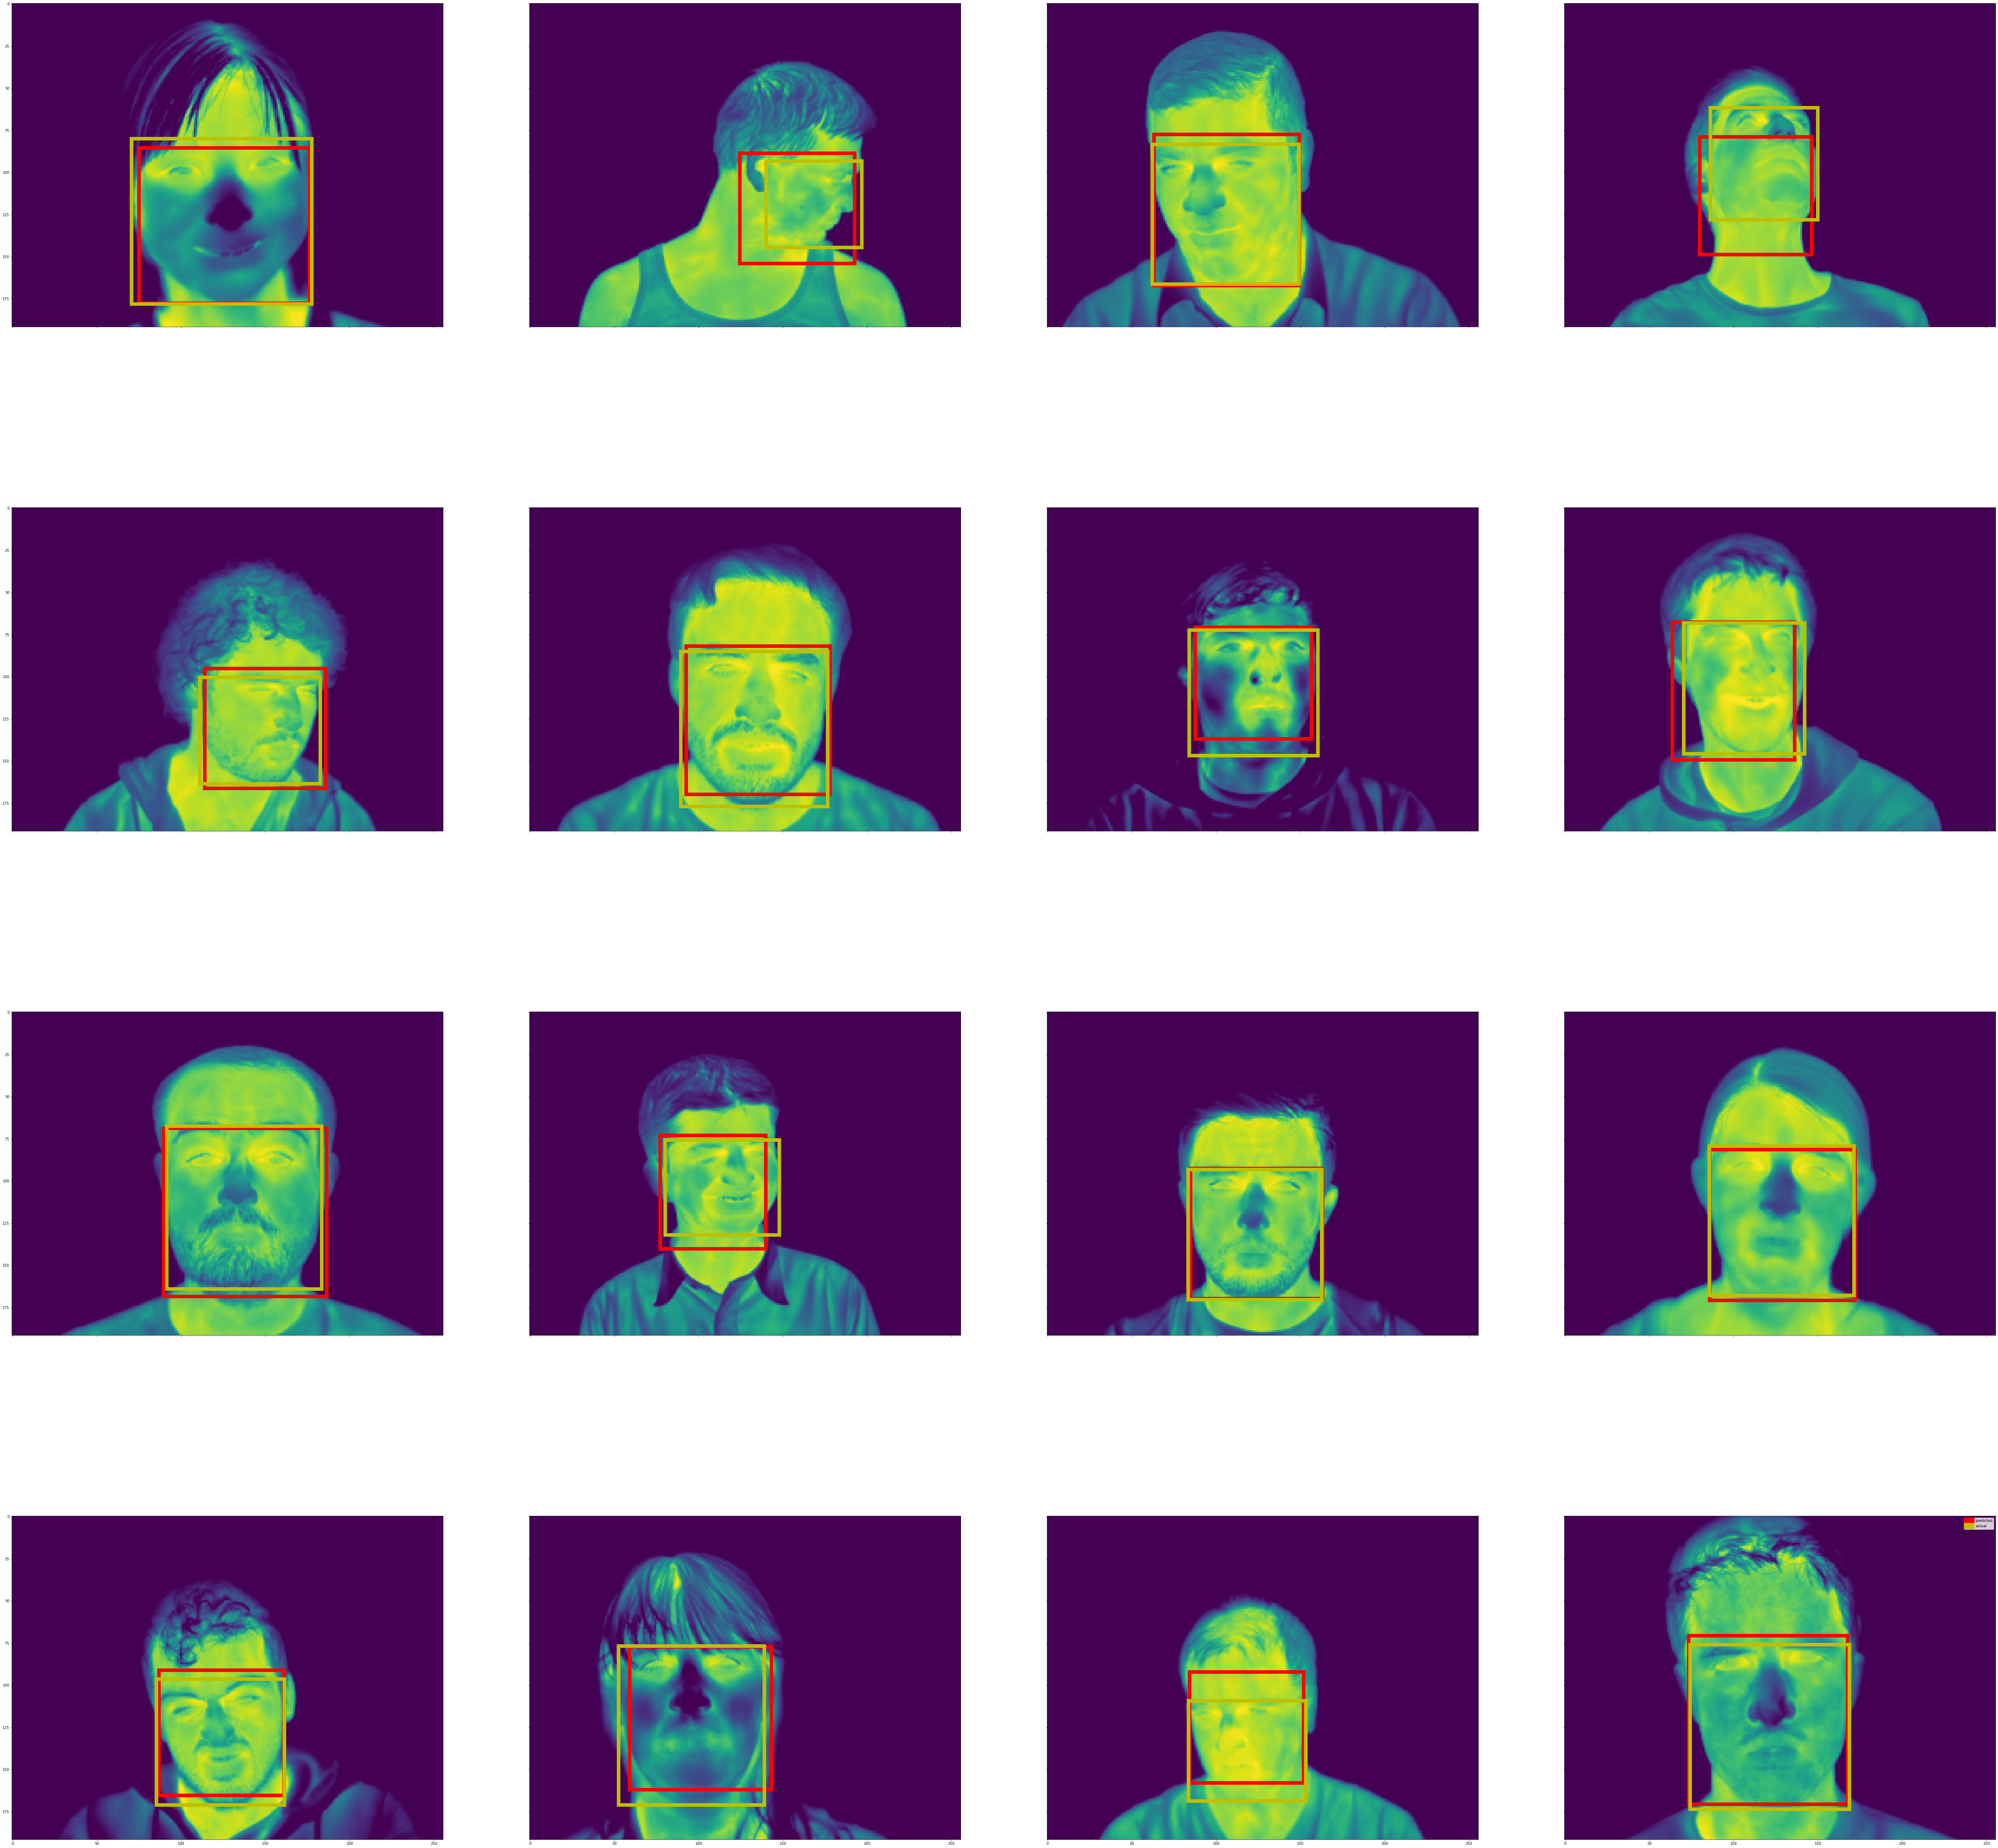

In [20]:
y_train_pred = model2.predict(x_train)
y_test_pred = model2.predict(x_test)
plot_predictions(y_test_pred)

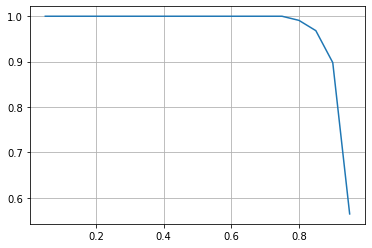

In [21]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

def intersection_over_union_set(setA, setB):
  iou = []
  n = setA.shape[0]
  assert setA.shape[0] == setB.shape[0]
  for i in range(n):
    b = bb_intersection_over_union(setA[i], setB[i])
    iou.append(b)

  x = [i * 0.05 for i in range(1, 20)]
  y = [sum([1 for i in iou if i > selected_x])/len(iou) for selected_x in x]
  plt.plot(x, y)
  plt.grid()
  plt.show()

intersection_over_union_set(y_test, y_test_pred)
  

In [22]:
import pandas as pd

metadeta = pd.read_csv('metadeta.csv')
subjects = (list(set(metadeta['subj'])))
n = len(subjects)
train_subjects = np.random.choice(subjects, size = int(n * 0.7), replace = False)
left_subjects = list(set(subjects) - set(train_subjects))
validation_subjects = np.random.choice(left_subjects, size = int(len(left_subjects) * 0.5), replace = False)
test_subjects = list(set(subjects) - (set(train_subjects).union(set(validation_subjects))))

train_indices = np.isin(metadeta['subj'], train_subjects)
train_indices = [i for i in range(metadeta['subj'].shape[0]) if train_indices[i]]

train_x = np.zeros((len(train_indices), 192, 256, 1))
train_y = np.zeros((len(train_indices), 4))
count = 0


for i in train_indices:
  train_x[count] = x[i]
  train_y[count] = y[i]
  count += 1

valid_indices = np.isin(metadeta['subj'], validation_subjects)
valid_indices = [i for i in range(metadeta['subj'].shape[0]) if valid_indices[i]]

valid_x = np.zeros((len(valid_indices), 192, 256, 1))
valid_y = np.zeros((len(valid_indices), 4))
count = 0

for i in valid_indices:
  valid_x[count] = x[i]
  valid_y[count] = y[i]
  count += 1

test_indices = np.isin(metadeta['subj'], test_subjects)
test_indices = [i for i in range(metadeta['subj'].shape[0]) if test_indices[i]]

test_x = np.zeros((len(test_indices), 192, 256, 1))
test_y = np.zeros((len(test_indices), 4))
count = 0

for i in valid_indices:
  test_x[count] = x[i]
  test_y[count] = y[i]
  count += 1



print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)
print(test_x.shape)
print(test_y.shape)

(2003, 192, 256, 1)
(2003, 4)
(425, 192, 256, 1)
(425, 4)
(507, 192, 256, 1)
(507, 4)


Epoch 1/100
16/16 [==============================] - 8s 511ms/step - loss: 0.0181 - val_loss: 0.0026
Epoch 2/100
16/16 [==============================] - 7s 439ms/step - loss: 0.0059 - val_loss: 0.0025
Epoch 3/100
16/16 [==============================] - 7s 444ms/step - loss: 0.0052 - val_loss: 0.0022
Epoch 4/100
16/16 [==============================] - 7s 447ms/step - loss: 0.0048 - val_loss: 0.0019
Epoch 5/100
16/16 [==============================] - 7s 443ms/step - loss: 0.0044 - val_loss: 0.0018
Epoch 6/100
16/16 [==============================] - 7s 440ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 7/100
16/16 [==============================] - 7s 439ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 8/100
16/16 [==============================] - 7s 438ms/step - loss: 0.0040 - val_loss: 0.0015
Epoch 9/100
16/16 [==============================] - 7s 435ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 10/100
16/16 [==============================] - 7s 436ms/step - loss: 0.0038 - val_lo

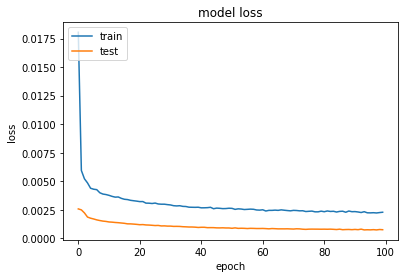

In [23]:
from tensorflow.keras import regularizers
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), padding = 'same', activation='relu', input_shape=(192, 256, 1)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(256, activation='relu', ))
model3.add(Dropout(0.5))
model3.add(Dense(4, activation='sigmoid'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model3.compile(loss='mean_squared_error', optimizer=sgd)
history = model3.fit(train_x, train_y, batch_size=128, epochs=100, validation_data = (valid_x, valid_y), verbose = 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

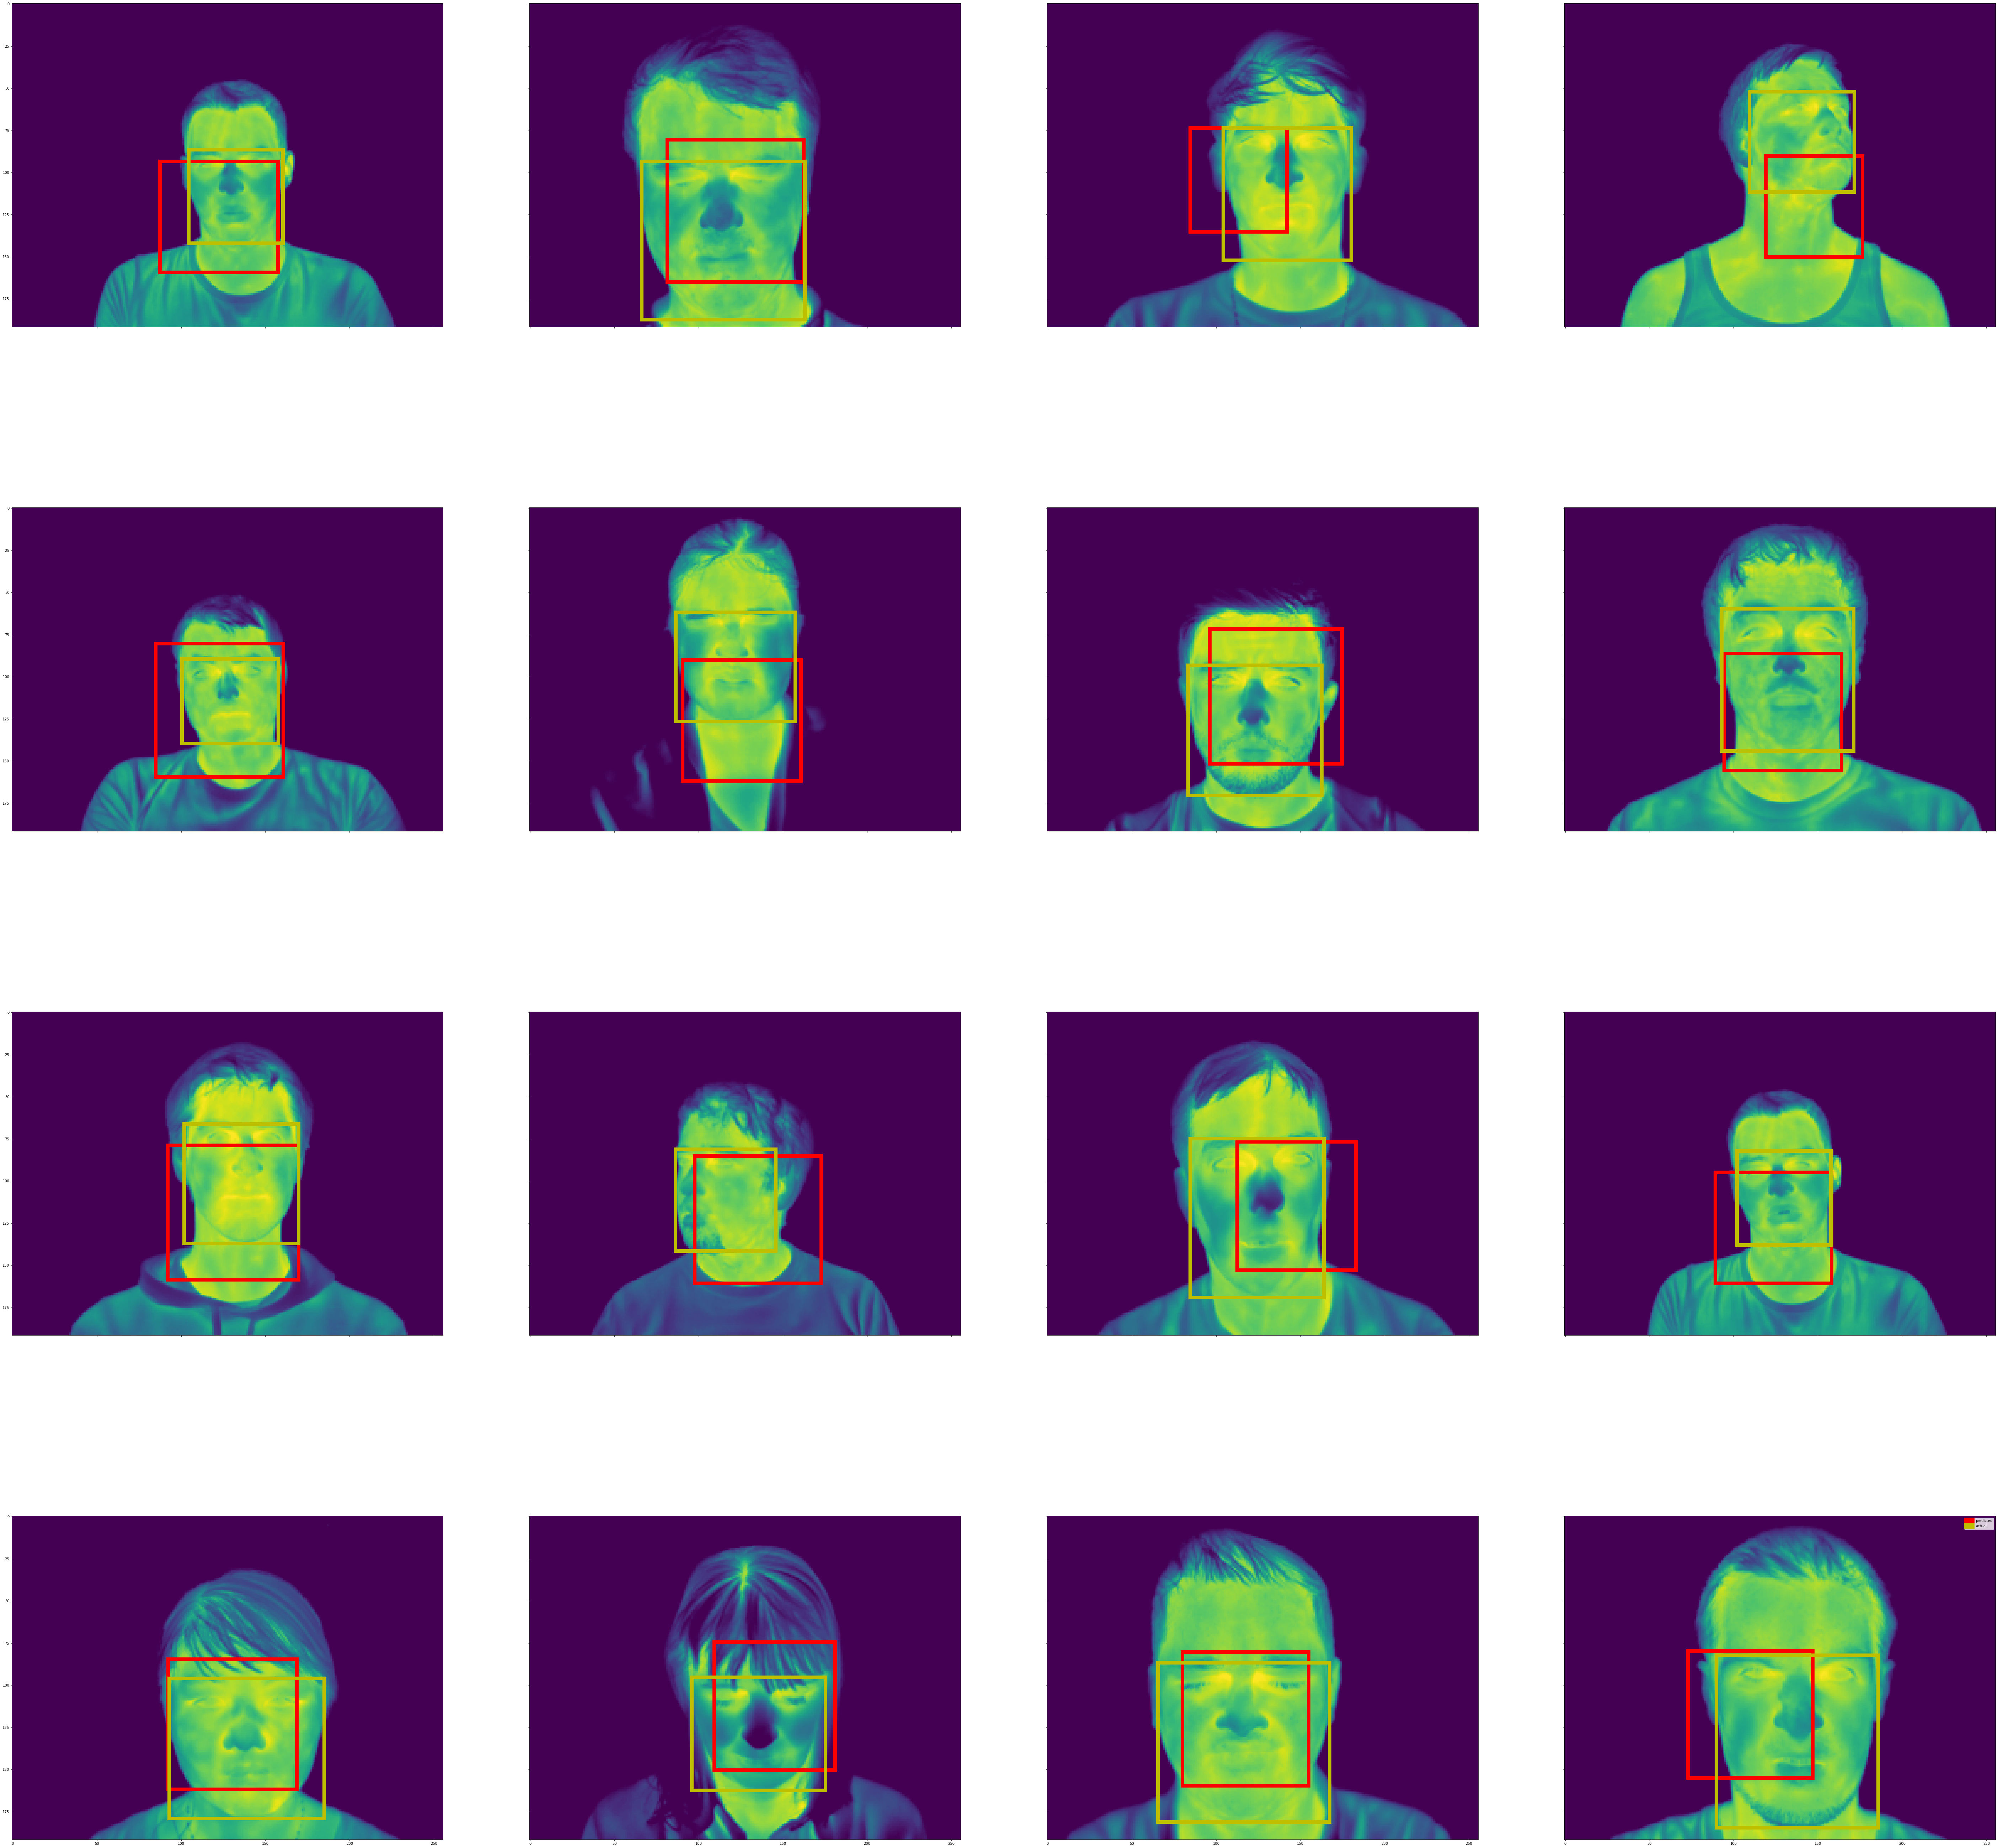

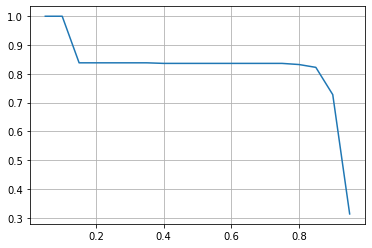

In [24]:
y_test_pred = model3.predict(test_x)
plot_predictions(y_test_pred)
intersection_over_union_set(test_y, y_test_pred)